In [1]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from rfpimp import *
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import collections as c
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [3]:
rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [4]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [5]:
X_train = pd.read_csv('../data/processed/first_quarter/X_train.csv')
y_train = pd.read_csv('../data/processed/first_quarter/y_train.csv')
y_train = y_train['module_not_completed']

X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_train.fillna(value = 0, inplace = True)
X_test.fillna(value = 0, inplace = True)

In [6]:
    predictions = rf_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

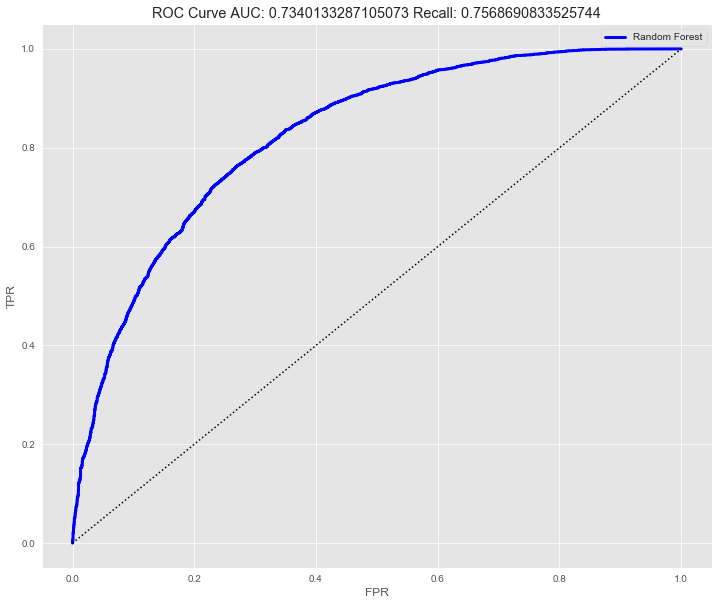

Best Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Roc Auc: 0.7340133287105073

Recall Score: 0.7568690833525744

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix:
 [[2151  621]
 [1485 4405]]


In [7]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(rf_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

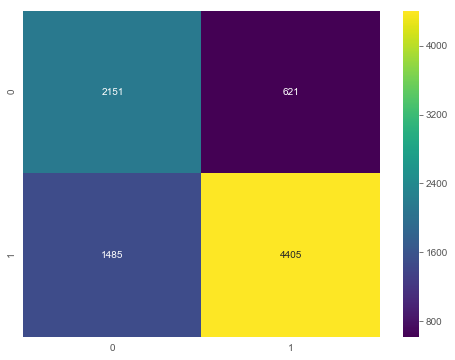

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=conf_mat, cmap='viridis', fmt='d')

## Model Improvement Over Baseline

## Baseline: Use proportion

In [9]:
proportion = y_test.sum() / y_test.shape[0] # proportion of student who do not complete
baseline_probas = np.array([proportion] * len(y_test)) # baseline probability

In [10]:
# randomly pedict proportion = true
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [11]:
    bl_roc_auc = roc_auc_score(y_test, baseline_preds)
    probas = baseline_probas
    bl_recall = recall_score(y_test, baseline_preds, average='micro')
    bl_class_report = classification_report(y_test, baseline_preds)

In [12]:
    print('\nBaseline Roc Auc: {}'.format(bl_roc_auc))
    print('\nBaseline Recall Score: {}'.format(bl_recall))
    print('\nBaseline Classification Report:\n {}'.format(bl_class_report))
    print('\nBaseline Confusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, baseline_preds)))


Baseline Roc Auc: 0.5114918923249269

Baseline Recall Score: 0.5245901639344263

Baseline Classification Report:
               precision    recall  f1-score   support

       False       0.59      0.59      0.59      5026
        True       0.43      0.43      0.43      3636

   micro avg       0.52      0.52      0.52      8662
   macro avg       0.51      0.51      0.51      8662
weighted avg       0.52      0.52      0.52      8662


Baseline Confusion Matrix:
 [[1563 2045]
 [2073 2981]]


## Baseline: Predict Majority Class

In [13]:
baseline_preds = np.zeros(len(y_test))
proportion = y_test.sum() / y_test.shape[0] # proportion of student who do not complete
baseline_probas = np.array([proportion] * len(y_test)) # baseline probability

In [14]:
    bl_roc_auc = roc_auc_score(y_test, baseline_preds)
    probas = baseline_probas
    bl_recall = recall_score(y_test, baseline_preds, average='micro')
    bl_class_report = classification_report(y_test, baseline_preds)

In [15]:
    print('\nBaseline Roc Auc: {}'.format(bl_roc_auc))
    print('\nBaseline Recall Score: {}'.format(bl_recall))
    print('\nBaseline Classification Report:\n {}'.format(bl_class_report))
    print('\nBaseline Confusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, baseline_preds)))


Baseline Roc Auc: 0.5

Baseline Recall Score: 0.5802355114292311

Baseline Classification Report:
               precision    recall  f1-score   support

       False       0.58      1.00      0.73      5026
        True       0.00      0.00      0.00      3636

   micro avg       0.58      0.58      0.58      8662
   macro avg       0.29      0.50      0.37      8662
weighted avg       0.34      0.58      0.43      8662


Baseline Confusion Matrix:
 [[   0    0]
 [3636 5026]]


## Baseline: Use demographics

In [16]:
bl_X_train = X_train[['gender_M', 'gender_nan', 'region_East Midlands Region', 'region_Ireland',
                    'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region', 'region_nan',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification',
       'highest_education_nan', 'imd_band_10-20', 'imd_band_20-30%',
       'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
       'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%',
       'imd_band_90-100%', 'imd_band_nan', 'age_band_35-55', 'age_band_55<=',
       'age_band_nan', 'disability_Y', 'disability_nan']]

bl_X_test = X_test[['gender_M', 'gender_nan', 'region_East Midlands Region', 'region_Ireland',
                    'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region', 'region_nan',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification',
       'highest_education_nan', 'imd_band_10-20', 'imd_band_20-30%',
       'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
       'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%',
       'imd_band_90-100%', 'imd_band_nan', 'age_band_35-55', 'age_band_55<=',
       'age_band_nan', 'disability_Y', 'disability_nan']]

In [17]:
bl_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
bl_model.fit(bl_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
baseline_preds = bl_model.predict(bl_X_test)

In [20]:
    bl_roc_auc = roc_auc_score(y_test, baseline_preds)
#     probas = baseline_probas
    bl_recall = recall_score(y_test, baseline_preds, average='micro')
    bl_class_report = classification_report(y_test, baseline_preds)

In [21]:
    print('\nBaseline Roc Auc: {}'.format(bl_roc_auc))
    print('\nBaseline Recall Score: {}'.format(bl_recall))
    print('\nBaseline Classification Report:\n {}'.format(bl_class_report))
    print('\nBaseline Confusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, baseline_preds)))


Baseline Roc Auc: 0.5573738780563293

Baseline Recall Score: 0.5977834218425306

Baseline Classification Report:
               precision    recall  f1-score   support

       False       0.62      0.81      0.70      5026
        True       0.54      0.31      0.39      3636

   micro avg       0.60      0.60      0.60      8662
   macro avg       0.58      0.56      0.54      8662
weighted avg       0.58      0.60      0.57      8662


Baseline Confusion Matrix:
 [[1111  959]
 [2525 4067]]


## Random Forest Model:

In [22]:
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))


Roc Auc: 0.7340133287105073

Recall Score: 0.7568690833525744

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix:
 [[2151  621]
 [1485 4405]]


## Choosing a Threshold

In [23]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:200]

,fprs,tprs,Thresholds
800,0.133113,0.566057,0.717140
1000,0.171617,0.625746,0.688625
1200,0.213696,0.692002,0.651421
1400,0.257701,0.748309,0.613464
1600,0.308581,0.795862,0.576925
1800,0.360286,0.842220,0.537464
2000,0.419417,0.882411,0.491877
2200,0.487074,0.917429,0.436776
2400,0.573982,0.946677,0.369149
2600,0.669417,0.972742,0.288895


In [24]:
    t = 0.5 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix at Threshold 0.5:
 [[2151  621]
 [1485 4405]]


In [28]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78      5026
        True       0.69      0.73      0.71      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.74      0.75      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix at Threshold 0.4:
 [[2637 1172]
 [ 999 3854]]


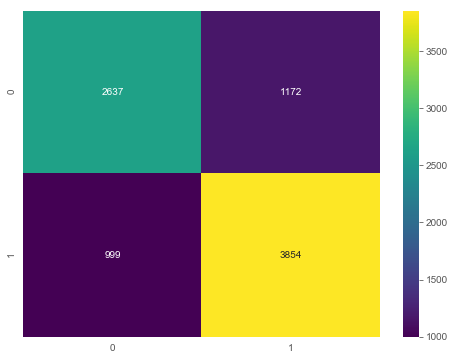

In [36]:
t = 0.4 # threshold for predicting positive    
predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
cm = standard_confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=cm, cmap='viridis', fmt='d')


In [32]:
cm

array([[2637, 1172],
       [ 999, 3854]])

In [ ]:
    t = 0.3 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))

In [ ]:
    t = proportion # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))

## Feature Importance

In [ ]:
feat_imp = importances(rf_model, X_test, y_test)

In [ ]:
feat_imp.sort_values(by='Importance', ascending=False)[0:10]

# RFE